## **Installations & Imports**

In [617]:
%pip install pandas
%pip install yfinance
%pip install scikit-learn
%pip install projectpro

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [618]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, SimpleRNN, Dense
from keras.models import Sequential
from keras.layers import Dense

from projectpro import model_snapshot, checkpoint
import pandas_ta as ta

In [619]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

## **Time Series Data**

### Retreive Data

In [620]:
now = datetime.now() 
start = now - relativedelta(years=4)
dataset = yf.download('NVDA', start, now)
print(dataset)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-02-19   75.372498   78.852501   75.372498   78.675003   78.368774   
2020-02-20   78.192497   79.080002   74.087502   77.175003   76.874603   
2020-02-21   76.047501   76.300003   72.665001   73.517502   73.231346   
2020-02-24   67.547501   70.467499   67.000000   68.320000   68.054077   
2020-02-25   69.074997   69.697502   64.489998   65.512497   65.257484   
...                ...         ...         ...         ...         ...   
2024-02-12  726.000000  746.109985  712.500000  722.479980  722.479980   
2024-02-13  704.000000  734.500000  696.200012  721.280029  721.280029   
2024-02-14  732.020020  742.359985  719.380005  739.000000  739.000000   
2024-02-15  738.690002  739.750000  724.000000  726.580017  726.580017   
2024-02-16  741.000000  744.020020  725.010

### Partition Training & Testing Set

In [621]:
def train_test_split(dataset, end, columns=['Close']):
    start_test = end - relativedelta(days=14)
    end_test = end

    end_train = start_test
    start_train = end_train - relativedelta(years=3)

    train = dataset.loc[start_train:end_train, columns].values
    test = dataset.loc[start_test:end_test, columns].values
    
    return train, test


In [622]:
train_set, test_set = train_test_split(dataset, now)

In [623]:
def train_test_plot(train_set, test_set):
    plt.figure(figsize=(16, 4))
    plt.plot(train_set, label=f"Train (Before {test_set[0][0]})")
    plt.plot(range(len(train_set), len(train_set) + len(test_set)), test_set, label=f"Test ({test_set[0][0]} and beyond)")
    plt.legend()
    plt.title("Stock Price")
    plt.show()

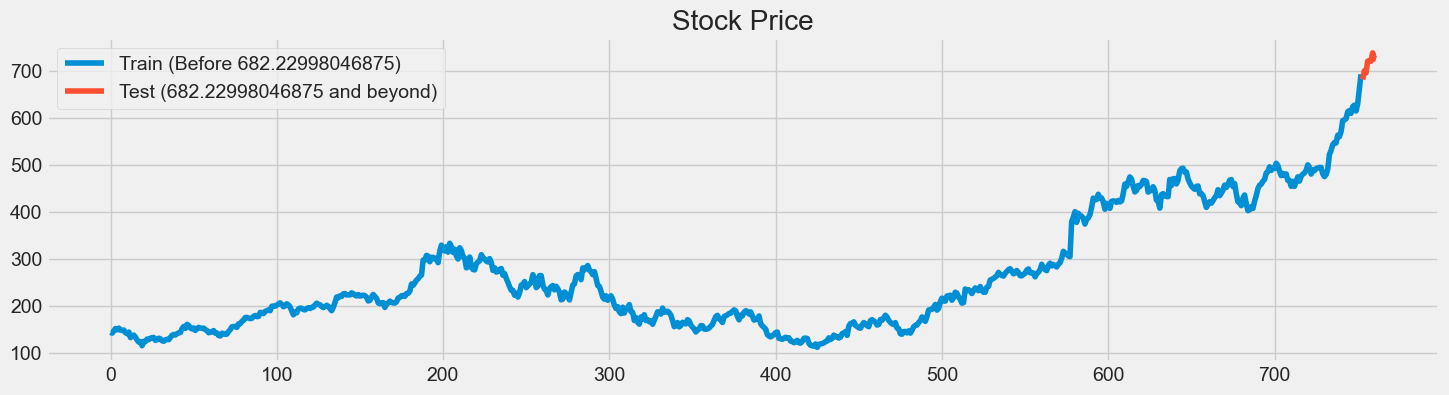

In [624]:
train_test_plot(train_set, test_set)

### Scaling Data Set 

In [625]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = train_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Windows

In [626]:
n_steps = 1
features = 1

In [627]:
# Split sequence of data into input-output pairs consisteing of n_seps
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [628]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [629]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

### Evaluation

In [630]:
def plot_predictions(test, predicted, title):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()

In [631]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

## **RNN**

### Set Up

In [632]:
def plot_loss(history):
    plt.figure(figsize = (15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

In [633]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=125, input_shape=(n_steps, features)))
model_rnn.add(Dense(units=1))

In [634]:
# model_rnn = Sequential()
# model_rnn.add(SimpleRNN(units=128, input_shape=(n_steps, features), return_sequences=True))
# model_rnn.add(SimpleRNN(units=64, return_sequences=True))  # Add another RNN layer
# model_rnn.add(SimpleRNN(units=32))  # Add one more RNN layer
# model_rnn.add(Dense(units=1))

In [635]:
# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [636]:
history = model_rnn.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
model_snapshot("34db30")

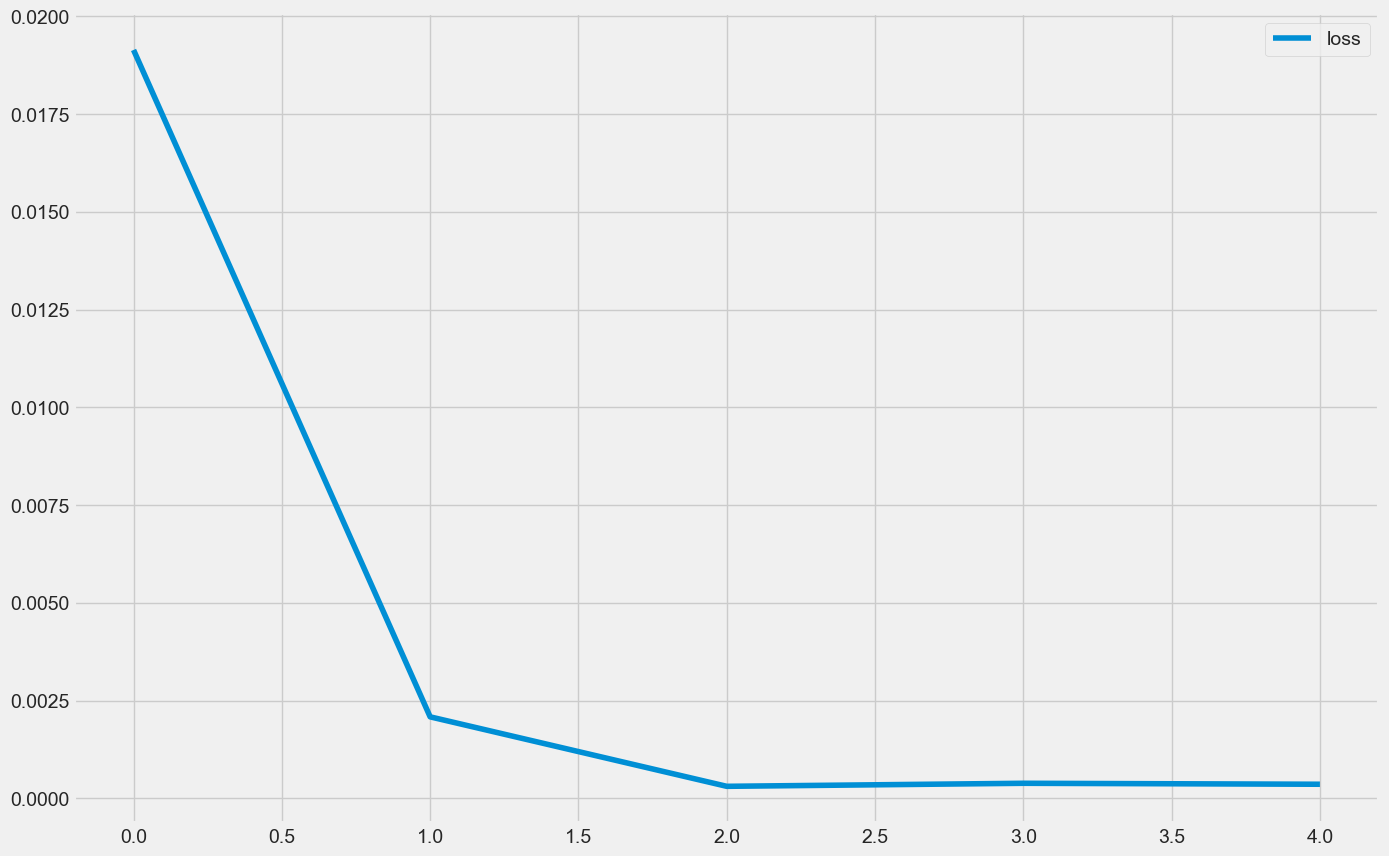

In [637]:
plot_loss(history)

### Prediction

In [638]:
# Scaling
inputs = sc.transform(test_set.reshape(-1, 1))

In [639]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(-1, n_steps, features)

In [640]:
# Prediction
predicted_stock_price = model_rnn.predict(X_test)
# Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 87ms/step


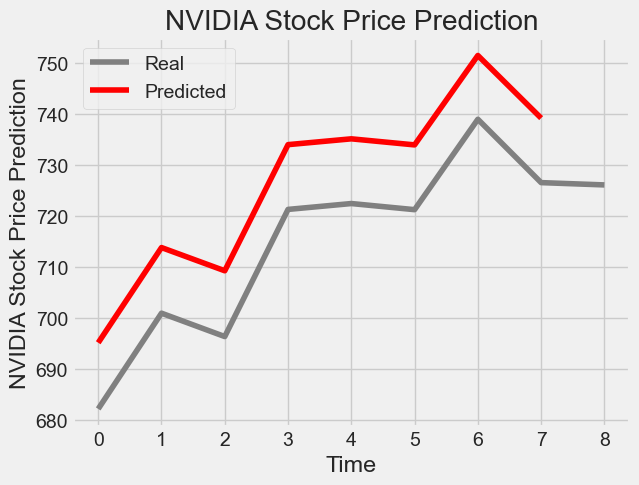

In [641]:
plot_predictions(test_set, predicted_stock_price, "NVIDIA Stock Price Prediction")

### Sequence Generation

In [642]:
steps_in_future = 7

In [643]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model:Sequential, steps_future: int):
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))
    inputs = high_dataset[:n_steps]

    for _ in range(steps_future):
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)
        inputs = np.append(inputs, curr_pred, axis=0)

    return sc.inverse_transform(inputs[n_steps:])

In [644]:
results = sequence_generation(dataset, sc, model_rnn, steps_in_future)

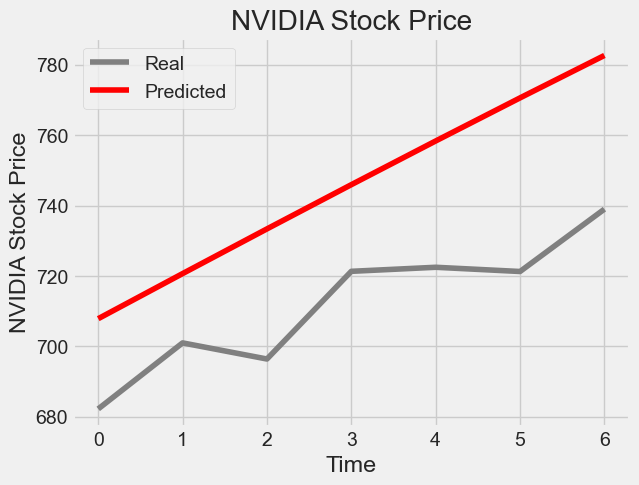

In [645]:
plot_predictions(test_set[:steps_in_future], results, "NVIDIA Stock Price")

## **LSTM**

In [646]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

In [647]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(units=128, input_shape=(n_steps, features), return_sequences=True))
# model_lstm.add(LSTM(units=64, return_sequences=True))  # Add another LSTM layer
# model_lstm.add(LSTM(units=32))  # Add one more LSTM layer
# model_lstm.add(Dense(units=1))

In [648]:
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [649]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

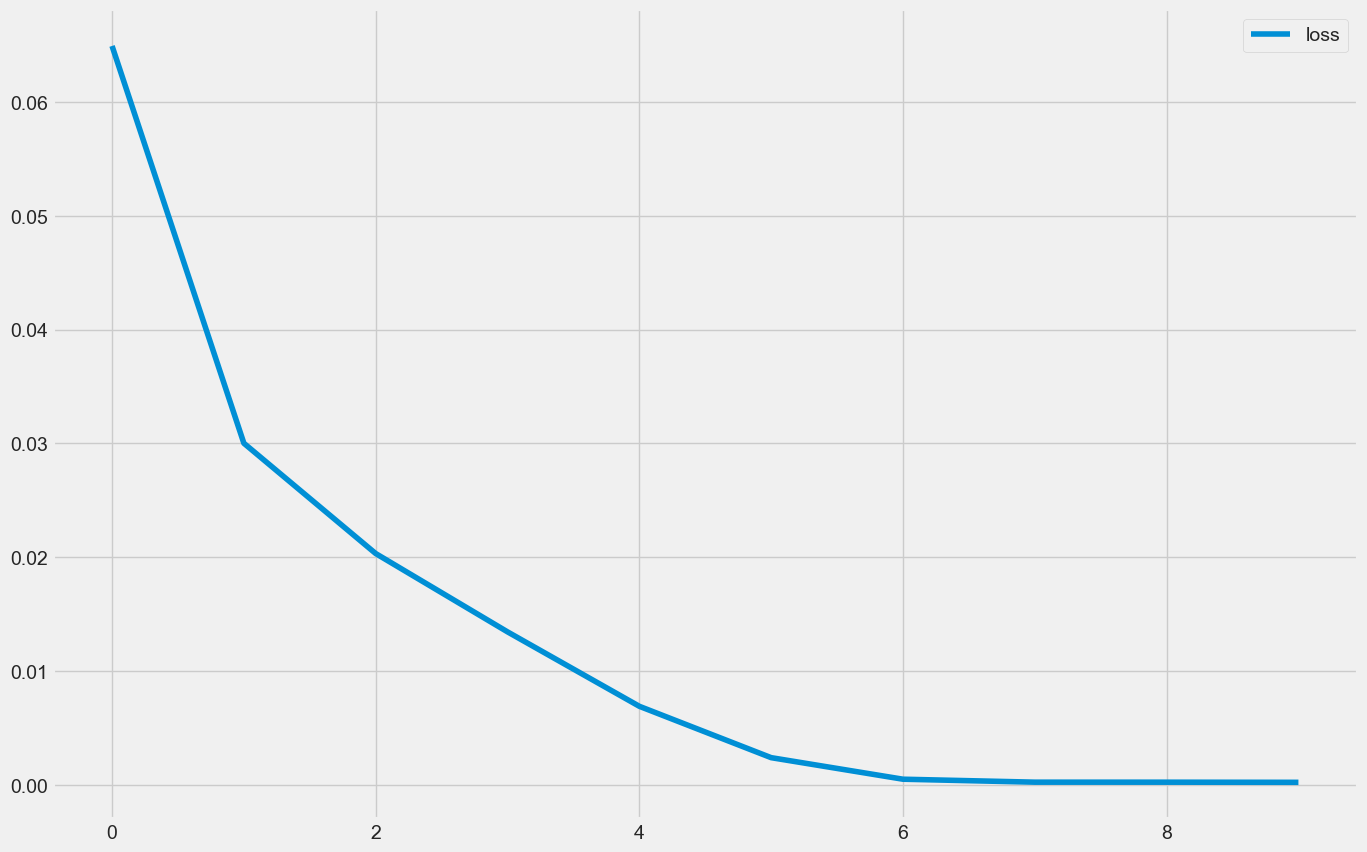

In [650]:
plot_loss(history)

### Prediction

In [651]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 246ms/step


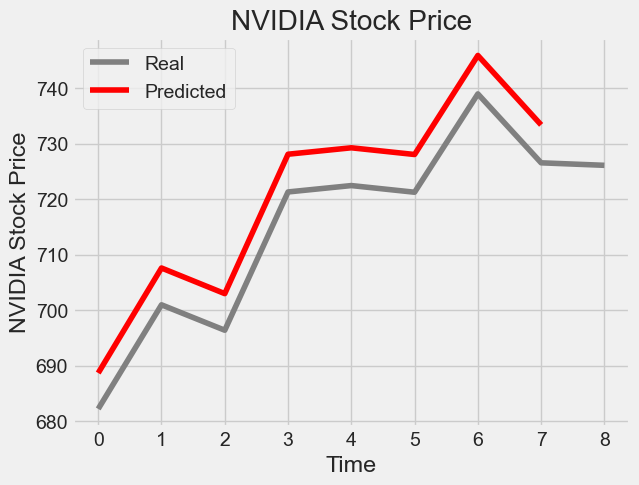

In [652]:
plot_predictions(test_set, predicted_stock_price, "NVIDIA Stock Price")

### Sequence Generation

In [653]:
results = sequence_generation(dataset, sc, model_lstm, steps_in_future)

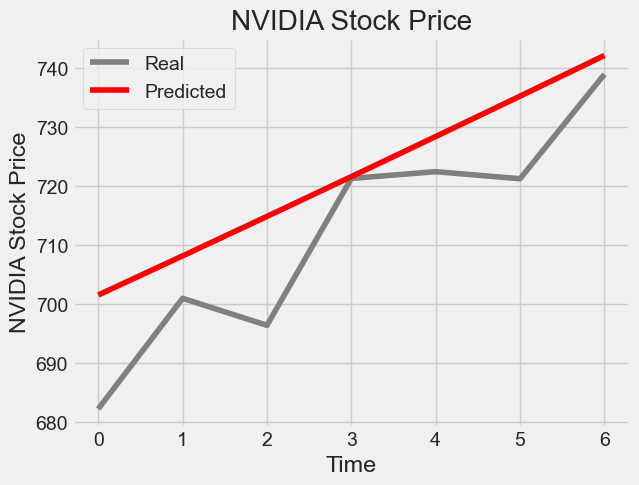

In [654]:
plot_predictions(test_set[:steps_in_future], results, "NVIDIA Stock Price")

## **Multiple Input LSTM**

In [655]:
mv_features = 6

In [656]:
multi_variate_df = yf.download('NVDA', start, now)

[*********************100%***********************]  1 of 1 completed


### Other Indicators

In [657]:
multi_variate_df['RSI'] = ta.rsi(multi_variate_df.Close, length=15)
multi_variate_df['EMAF'] = ta.ema(multi_variate_df.Close, length=20)
multi_variate_df['EMAM'] = ta.ema(multi_variate_df.Close, length=100)
multi_variate_df['EMAS'] = ta.ema(multi_variate_df.Close, length=150)

In [658]:
multi_variate_df['Target'] = multi_variate_df['Adj Close'] - dataset.Open
multi_variate_df['Target'] = multi_variate_df['Target'].shift(-1)
multi_variate_df.dropna(inplace=True)
multi_variate_df.drop(['Volume', 'Close'], axis=1, inplace=True)

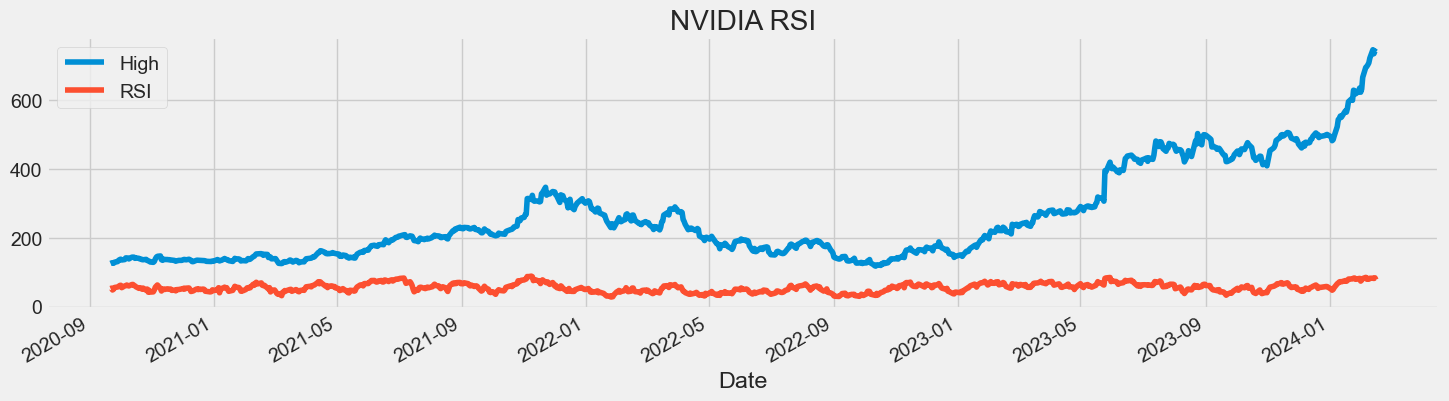

In [659]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'RSI']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA RSI")
plt.show()

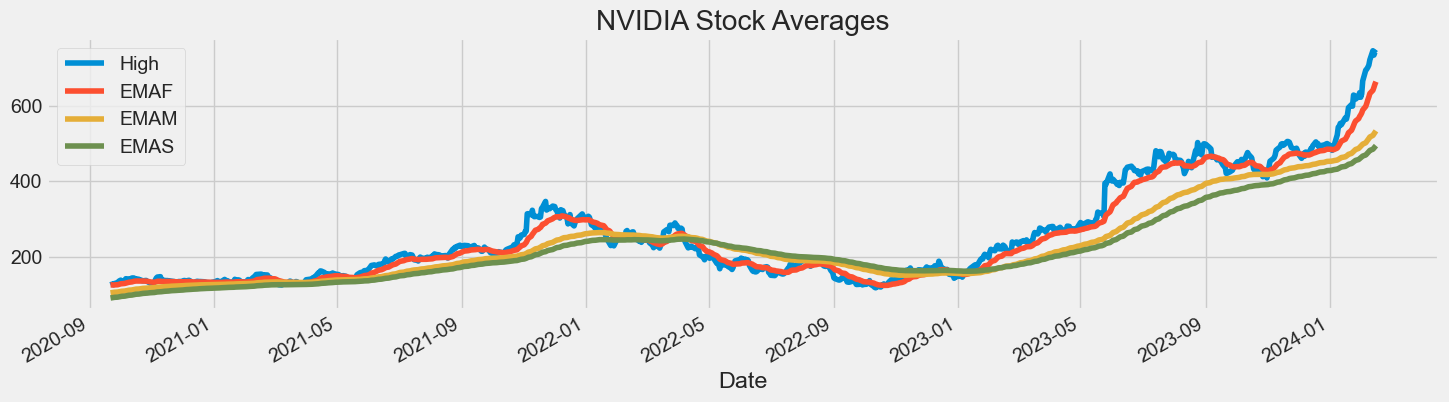

In [660]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'EMAF', 'EMAM', 'EMAS']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA Stock Averages")
plt.show()

In [661]:
feat_columns = ['Open', 'High', 'RSI', 'EMAF', 'EMAM', 'EMAS']
label_col = ['Target']

### Partitioning Data

In [662]:
mv_training_set, mv_test_set = train_test_split(multi_variate_df, now, feat_columns + label_col)

In [663]:
X_train = mv_training_set[:, :-1]
y_train = mv_training_set[:, -1]

X_test = mv_test_set[:, :-1]
y_test = mv_test_set[:, -1]

### Scaling Data

In [664]:
mv_sc = MinMaxScaler(feature_range=(0, 1))
X_train = mv_sc.fit_transform(X_train).reshape(-1, 1, mv_features)
X_test = mv_sc.transform(X_test).reshape(-1, 1, mv_features)

### Model

In [665]:
model_mv = Sequential()
model_mv.add(LSTM(units=125, input_shape=(1, mv_features)))
model_mv.add(Dense(units=1))
# Compiling the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model_mv.compile(optimizer=optimizer, loss="mse")
# model_mv.compile(optimizer="RMSprop", loss="mse")

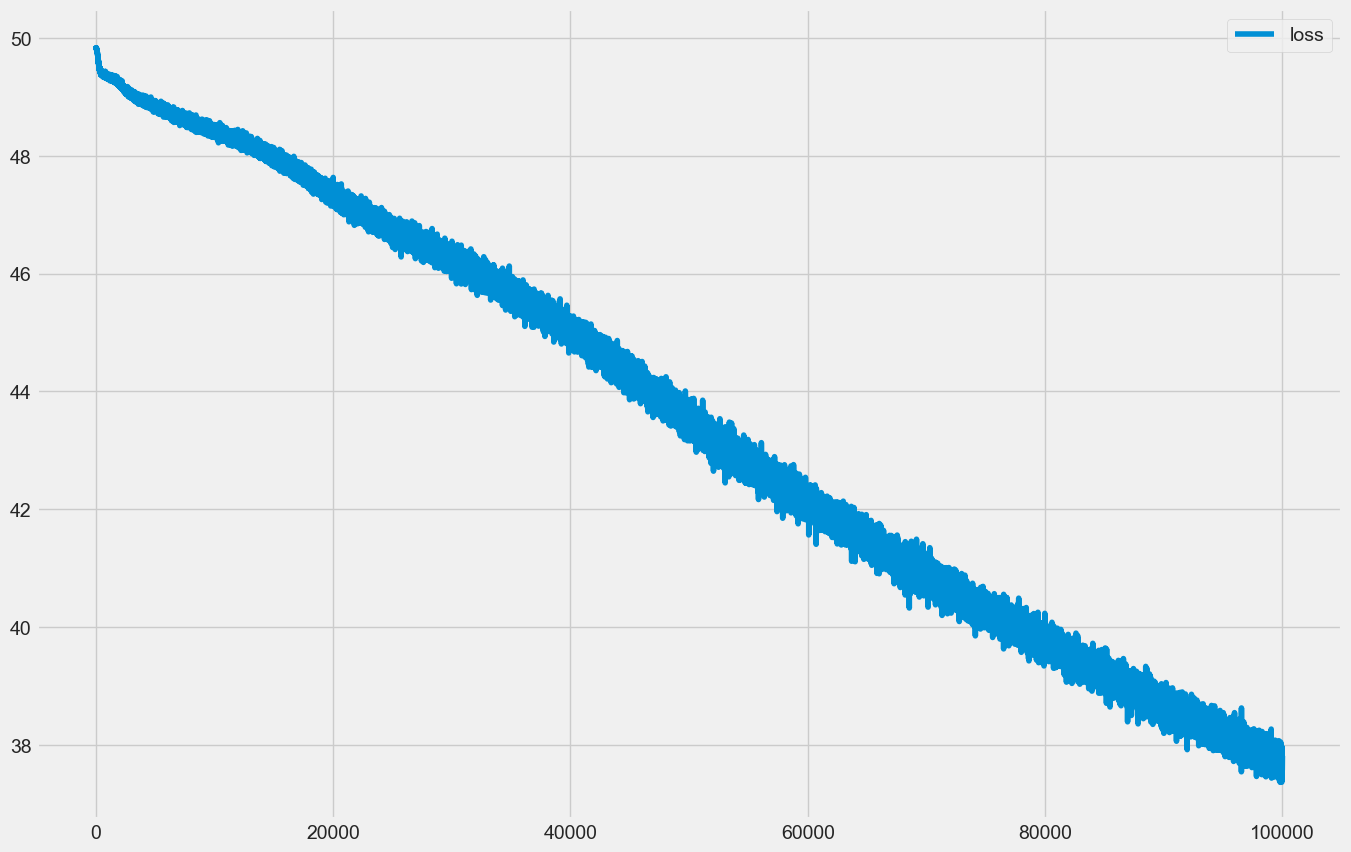

In [666]:
history = model_mv.fit(X_train, y_train, epochs=100000, batch_size=64, verbose=0)
model_snapshot("34db30")
plot_loss(history)

In [667]:
# predictions = model_mv.predict(X_test)
# plot_predictions(y_test, predictions, "NVIDIA Stock Price")

1/1 [==============================] - 0s 227ms/step


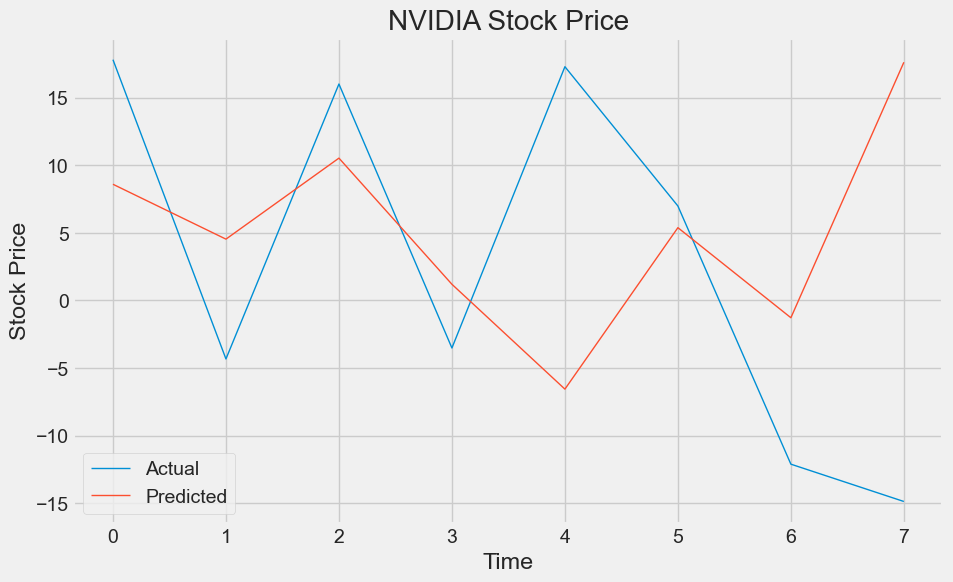

In [668]:
predictions = model_mv.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linewidth=1)  # Adjust linewidth here
plt.plot(predictions, label='Predicted', linewidth=1)  # Adjust linewidth here
plt.title("NVIDIA Stock Price")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [669]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 244.83291350068512
Root Mean Squared Error (RMSE): 15.647137549746443
Mean Absolute Error (MAE): 12.126799613237381
R-squared (R2) Score: -0.5649110451950645
